In [1]:
import torch
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# autograd globally off
torch.set_grad_enabled(False)

## Optimizer

In [3]:
class Stochastic_gradient_descent(object):
    def __init__(self, learning_rate=10**-3):
        """
        :param learning_rate: learning rate
        """
        self.learning_rate=learning_rate

    def __call__(self, *input):
        """
        Perform parameter update
        :param input: model.parameters()
        """
        
        # Iterate through the layers of the network and update parameters of the Linear ones
        for layer in input[0]:
            if isinstance(layer, Linear):
                
                # #Updating the weights and biases (SGD)
                layer.weights.data = layer.weights.data -self.learning_rate * layer.weights.grad
                if layer.biases is not None:
                    layer.biases.data=layer.biases.data-self.learning_rate*layer.biases.grad

    def param(self):
        return []

## Layer Modules

In [4]:
class Module (object):
    def __init__(self):
        self.parameters = []
    def forward (self , * input ):
        raise NotImplementedError
    def backward (self , * gradwrtoutput ):
        raise NotImplementedError
    def param (self):
        return self.parameters

In [5]:
class Parameter(object):
    def __init__(self, data, requires_grad):
        self.data = data
        self.grad = None
#         self.skip_decay = skip_decay
        self.requires_grad = requires_grad

In [6]:
class  Linear(Module):
    #Fully Connected Layer
    def __init__(self,input_size,output_size,requires_grad=True, bias=True, initialization='uniform'):
    # Initializing weights and biases with uniformly distributed values between [0,1]    
        
        self.weights=Parameter(torch.empty(output_size,input_size),requires_grad)
        self.biases=Parameter(torch.empty(output_size,1),requires_grad) if bias else None
        self.requires_grad=requires_grad
        
        if initialization=='uniform':
            # Initializing weights and biases with uniformly distributed values between [0,1]
            self.weights.data=self.weights.data.normal_()
            self.biases.data=self.biases.data.normal_()
        elif initialization=='Xavier':
            # Initialization of parameters with normally distributed values with 
            # std= sqrt(2/(width_layer + height_layer))   
            std = math.sqrt(2 / (self.weights.data.size(0) + self.weights.data.size(1)))
            self.biases.data = self.biases.normal_(0, std)
            self.weights.data = self.weights.normal_(0, std)
        else:
            raise TypeError
        
    
    def  forward(self , x):
#         whether to compute the gradient in the backpropagation
#         whether to set biases in the calculation
        
        if self.requires_grad: 
            self.x = x

        a=torch.mm(self.weights.data,x)

        if self.biases is not None:

            a+=self.biases.data
            
        return a
        
    def backward(self , eta):
#       eta: gradients passed from previous layers
        
        if self.requires_grad:

            #Computing the gradient of the loss with respect to W, b and x
            self.weights.grad=torch.mm(eta,self.x.T)
            if self.biases is not None:
                self.biases.grad=torch.einsum('ij->i', eta).view(-1,1)
                
            eta=torch.mm(self.weights.data.T,eta)

#             #Updating the weights and biases (SGD)
#             self.weights.data=self.weights.data-self.gamma*self.weights.grad
#             if self.biases is not None:
#                 self.biases.data=self.biases.data-self.gamma*self.biases.grad
                
            return eta
              
    def param(self):
        
        return  [(self.weights.data,self.weights.grad),(self.biases.data,self.biases.grad)]

### Concatenate different layers

In [7]:
# concatenate different layers
class Sequential(Module):

    def __init__(self,layers):
        
        #Getting the sequence of layers
        self.layers=layers

    def forward(self , x):
        
        #Forwarding the input through each layer in sequence
        for layer in self.layers:
            x=layer.forward(x)
        
        #Returning the output of the last layer

        return x

    def backward(self , eta):
     
        #Backward propagating the gradient from the last layer to the first
        for layer in reversed(self.layers):
            eta=layer.backward(eta)
            
        #Returning the gradient of the first layer
        return eta
    
    def train(self, train_input, train_targets,test_input, test_targets, epochs,input_size, batch_size, loss_function,optimizer=Stochastic_gradient_descent()):
        
        #Training our model
        
        train_loss_history=[]
        train_accuracy=[]
        test_loss_history=[]
        test_accuracy=[]
        
        for epoch in range(epochs):

            for batch_idx in range(0,input_size,batch_size):


                #Getting the input and target batches
                input_batch=train_input[batch_idx:batch_idx+batch_size].T
                target_batch=train_targets[batch_idx:batch_idx+batch_size].T
                
                #Forward step
                
                pred=self.forward(input_batch)

                #Computing the loss
                
                loss=loss_function.forward(pred,target_batch)
                
                #Backward step
                eta=loss_function.backward()
                self.backward(eta)

                optimizer(self.layers)
            
            # get the training loss and accuracy
            train_pred=self.forward(train_input.T) 
            train_mse_loss=loss_function.forward(train_pred,train_targets.T)
            train_loss_history.append(train_mse_loss)
            train_accuracy_result=compute_accuracy(train_pred,train_targets.T)
            train_accuracy.append(train_accuracy_result)
            
            # get the testing loss and accuracy
            test_pred=self.forward(test_input.T)
            test_mse_loss=loss_function.forward(test_pred,test_targets.T)
            test_loss_history.append(test_mse_loss)
            test_accuracy_result=compute_accuracy(test_pred,test_targets.T)
            test_accuracy.append(test_accuracy_result)
            
            #Printing the results of the current iteration
            print("The average training loss at epoch {} is {}".format(epoch+1,loss),end='\r')
        
        #Print the test accuracy
        print('\n')
        print("The test accuracy is ", compute_accuracy(test_pred,test_targets.T).item())
        
        #Plotting the train and test loss and accuracy figure

        #Setting-up the plot
        plt.figure(figsize=(15,8))
        
        ax1 = plt.subplot(1,2,1)
        
        ax2 = plt.subplot(1,2,2)

        #Drawing and labeling the curves
        ax1.plot(train_loss_history, label="Training Loss")
        ax1.plot(test_loss_history, label="Test Loss")

        #Adding the title and axis labels
        ax1.set_title('Train VS Test Loss')
        ax1.set_ylabel('Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()

        #Saving the plot
        ax1.figure.savefig('loss.png')
        

        #Drawing and labeling the curves
        ax2.plot(train_accuracy, label="Train Accuracy")
        ax2.plot(test_accuracy, label="Test Accuracy")

        #Adding the title and axis labels
        ax2.set_title('Train VS Test Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend()

        #Saving the plot
        ax2.figure.savefig('accuracy.png')
        
       
            
    def param(self):
        
        params=[]
        
        #Getting the param list of each layer
        for layer in self.layers:
            
            for param in layer.param():
                
                params.append(param)
        
        return  params

## Activation functions:

In [8]:
class  ReLU(Module):
    
    def  forward(self , x):
        
        #Saving x for the backward

        self.x=x
        # return non-negative x
        
        return torch.max(torch.empty(self.x.size()).zero_(),x)
        
    def backward(self , eta):

        #Computing the gradient with respect to x
#         eta[self.x<=0] = 0
        y = torch.empty(eta[0].size()).zero_()
        return (torch.eq(y, torch.min(y, self.x))).type(torch.FloatTensor).mul(eta[0])
        
#         return eta
        
    def  param(self):
        return  []

In [9]:
#Hyperbolic Tangent Activation Module
class  Tanh(Module):
        
    
    def  forward(self , s):
        
        #Saving s for the backward
        self.s=s
        
        return 1-2/(1+math.exp(1)**(2*s))
        
    def backward(self , gradx):
        
        #Computing the gradient with respect to s
        grads=gradx*(4/(math.exp(1)**(self.s)+math.exp(1)**(-self.s))) #∇s tanh(s) = 4/(e^s+e^-s)
        
        return grads
        
    def  param(self):
        return  []

## Loss functions

In [10]:
#Mean Squared Error Loss Module
class  LossMSE(Module):
    
    def  forward(self , x, y):
        
        #Saving both s and y for the backpropagation
        self.x=x
        self.y=y
        return torch.mean((x-y)**2)
        
    def backward(self):
        
        #Computing the gradient of the loss with respect to x
        self.eta=2*(self.x-self.y)/(self.x.shape[1]*self.x.shape[0]) #∇x MSE(s,y)=2*(s-y)/N
        return self.eta
        
    def  param(self):
        return  []

## Function to compute the accuracy

In [11]:
#Helper function computing the accuracy of our predictions
def compute_accuracy(pred,target):
    return 1.*torch.sum((torch.max(pred,0)[1])==(torch.max(target,0)[1]))/target.shape[1]

## Function to generate the training and testing data

In [12]:
def generate_data(num):
#   using pytorch tensor operation
#   return the generated random points and labels
    random_points = torch.rand((num, 2))
    targets=(torch.sum((random_points-0.5)**2,axis=1)*(2*math.pi)<1)
    # check if the point is in the circle centered at (0.5,0.5) of radius 1/sqrt(2*math.pi)
    return random_points, torch.stack([~targets,targets]).T*1

## Train and test the model

In [13]:
#Initializing the model
model=Sequential([Linear(2,25),ReLU(),Linear(25,25),ReLU(),Linear(25,25),ReLU(),Linear(25,2)])
# generating the training data and testing data:
train_input,train_targets=generate_data(1000)
test_input,test_targets=generate_data(1000)

The average training loss at epoch 3000 is 0.183621525764465334

The test accuracy is  0.8320000171661377


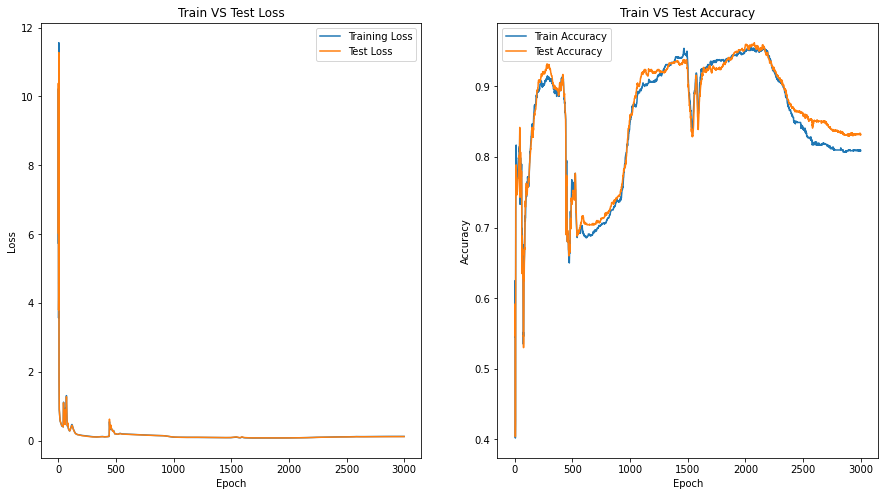

In [14]:
# the model parameters
input_size=1000
batch_size=25
epochs=3000
loss_function=LossMSE()

# train the model

model.train(train_input,train_targets,test_input,test_targets,epochs,input_size,batch_size,loss_function)